In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
# readin data_naming datafiles
#data_naming = pd.read_csv('naming_simu_w7s150.csv')
data_naming = pd.read_csv('lexdec_simu_w5s100.csv')

#data_naming = data_naming.drop(data_naming[np.isnan(data_naming.cosine) == 1].index)
data_naming.reset_index(drop=True,inplace=True) # reset the row index
print("Total num of trials: {}".format(len(data_naming)))
#data_naming.head()

Total num of trials: 13208


## Data preprocessing (cleaning)

### Step 1: Remove all trials of a target if one of its prime is missing

In [9]:
# remove all primes of a target if any one prime of the target is missing
targets = data_naming["target"].values.tolist()

# extract all targets w/o repetition
tarlist = []
for word in targets:
    if word not in tarlist:
        tarlist.append(word)
    else:
        continue
#print(tarlist)

# delete every trial with a target which doesn't count to 8 (i.e. 2 isi * 4 condition)
for target in tarlist:
    tar_trials = data_naming[(data_naming["target"]== target)]
    if tar_trials.shape[0] == 8:
        continue
    else:
        data_naming = data_naming.drop(data_naming[data_naming["target"]== target].index)

data_naming.reset_index(drop=True,inplace=True) # reset the row index

print("Total number of trials after removing targets with missing primes: {}".format(len(data_naming)))

Total number of trials after removing targets with missing primes: 13112


In [12]:
data_naming[(data_naming["condition"]== "unrel_strong")|(data_naming["condition"]== "unrel_weak")]["cosine"].describe()

count    6556.000000
mean        0.085682
std         0.163906
min        -0.306913
25%        -0.026743
50%         0.066817
75%         0.188561
max         0.776841
Name: cosine, dtype: float64

In [96]:
# save the current dataframe as a datafile, for ANOVA analysis on cosine similarity
data_naming.to_csv('data_cosine_w7s150.csv')

### Step 2: Prepare priming effect data for regressing cosine similarities on RTs

In [4]:
# calculate priming effect
data_primingeffect = pd.DataFrame(columns=["isi","prime", "prime_un","target","condition","prim_diff_RT","diff_cosine"])

isi = ["50","1050"]
condition = ["strong", "unrel_strong", "unrel_weak", "weak"]

for i in range(len(data_naming)):
    #print(i)
    isi_current = data_naming.loc[i,"isi"]
    prime_current = data_naming.loc[i,"prime"]
    target_current = data_naming.loc[i,"target"]
    meanRT_current = data_naming.loc[i,"meanRT"]
    cos_current = data_naming.loc[i,"cosine"]
    
    if data_naming.loc[i,"condition"]=="strong":
        ind = data_naming[(data_naming["isi"]==int(isi_current)) & (data_naming["target"]==target_current) & (data_naming["condition"]=="unrel_strong")]
        #print(len(ind.index))
        if len(ind.index) == 0:
            continue
        else:
            meanRT_minu = ind["meanRT"].values[0]
            cos_minu = ind["cosine"].values[0]
            priming_effect_RT = meanRT_minu - meanRT_current
            priming_effect_cosine = cos_current - cos_minu
            
            df = pd.DataFrame([(isi_current, prime_current, ind["prime"].values[0], target_current, data_naming.loc[i,"condition"], priming_effect_RT, priming_effect_cosine)], columns=["isi","prime", "prime_un","target","condition","prim_diff_RT","diff_cosine"])
            data_primingeffect = data_primingeffect.append(df,ignore_index=True)
    elif data_naming.loc[i,"condition"]=="weak":
        ind = data_naming[(data_naming["isi"]==int(isi_current)) & (data_naming["target"]==target_current) & (data_naming["condition"]=="unrel_weak")]
        
        if len(ind.index) == 0:
            continue
        else:
            meanRT_minu = ind["meanRT"].values[0]
            cos_minu = ind["cosine"].values[0]
            
            priming_effect_RT = meanRT_minu - meanRT_current
            priming_effect_cosine = cos_current - cos_minu
            df = pd.DataFrame([(isi_current, prime_current, ind["prime"].values[0], target_current, data_naming.loc[i,"condition"], priming_effect_RT, priming_effect_cosine)], columns=["isi","prime", "prime_un","target","condition","prim_diff_RT","diff_cosine"])
            data_primingeffect = data_primingeffect.append(df,ignore_index=True)
    else:
        continue

In [5]:
print("Total number of trials for priming effect: {}".format(len(data_primingeffect)))
print("Note that this number should equal half of the number yielded from the cell above")
data_naming = data_primingeffect

Total number of trials for priming effect: 6620
Note that this number should equal half of the number yielded from the cell above


### Step 3: Outlier removal (datapoints beyond +/-2std were thrown away)

In [6]:
#identify and remove outliers: any datapoint beyond +/-2std (aka \z\ >= 2) will be considered an outlier and removed from the dataset

#showchart = data_naming[['isi', 'condition',"meanRT"]].groupby(['isi', 'condition']).describe()
#print(showchart)

isi = ["50","1050"]
condition = ["strong", "unrel_strong", "unrel_weak", "weak"]

# detect and record outliers, with their indices
outliers = pd.DataFrame()
for i in range(2):
    isi_outlier = isi[i]
    for j in range(4):
        condition_outlier = condition[j]
        data_comb = data_naming[(data_naming.isi == int(isi_outlier)) & (data_naming.condition == condition_outlier)]
        
        # normalise the data to get the z-scores
        dt = data_comb.loc[:, 'prim_diff_RT':"diff_cosine"]
        data_comb_z = (dt - dt.mean()) / dt.std()
        
        outliers_comb = data_comb_z[(np.abs(data_comb_z.prim_diff_RT) > 2) | (np.abs(data_comb_z.diff_cosine) > 2)]
        # add isi*condition - maybe there're better ways?
        outliers_comb["isi"] = isi_outlier
        outliers_comb["condition"] = condition_outlier
        
        outliers = pd.concat([outliers,outliers_comb])
        
# build finailised data without outliers
data_finalised = data_naming.drop(outliers.index)
data_finalised.reset_index(drop=True,inplace=True) # leaving 5001 trials
print(len(data_finalised))

6072


C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

### Step 4: Save the file for inferential statistics in R

In [100]:
# save the preprocessed data into a csv file and switch to R for inferential stats
data_finalised_r = data_finalised
data_finalised_r.to_csv('data_f_lexdec_w7s150.csv')

### Extra step: Plotting (not part of the report; just wanted to get a feel about the data before analysis)

C:\Users\lenovo\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\lenovo\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


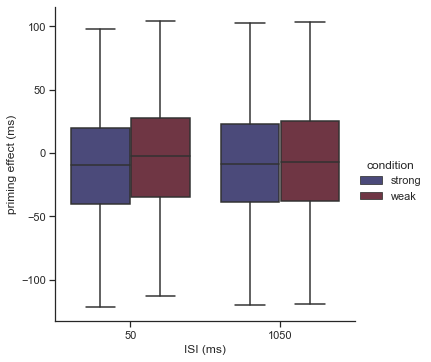

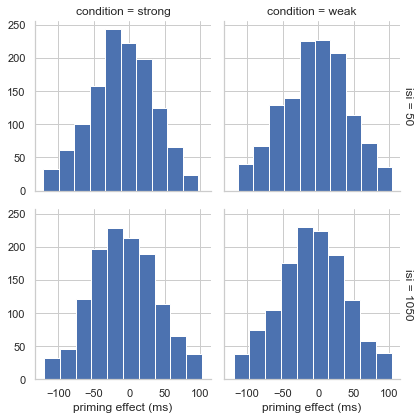

In [8]:
sns.set_theme(style="whitegrid")
# Data plotting: meanRTs
with sns.axes_style(style='ticks'): # box plot
    fig1 = sns.factorplot("isi", "prim_diff_RT", "condition", data=data_finalised, kind="box", palette = "icefire")
    fig1.set_axis_labels("ISI (ms)", "priming effect (ms)");

# grid plot: looks even better without outliers
grid = sns.FacetGrid(data_finalised, row="isi", col="condition", margin_titles=True)
grid.map(plt.hist, "prim_diff_RT");
grid.set_axis_labels("priming effect (ms)");

C:\Users\lenovo\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\lenovo\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


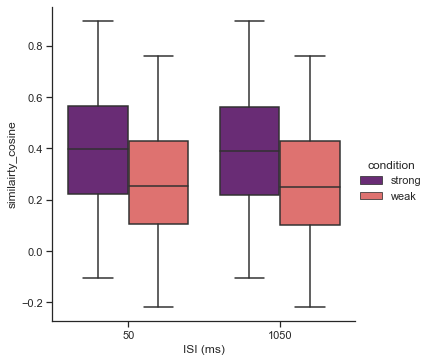

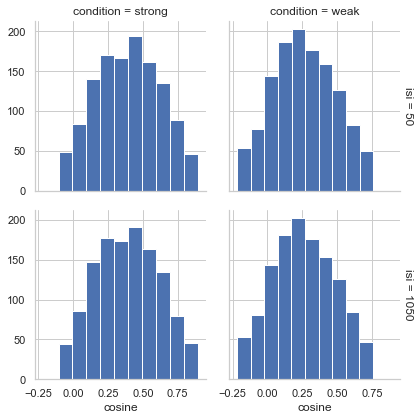

In [9]:
# Data plotting: cosine - looks neat!
with sns.axes_style(style='ticks'): # box plot
    fig1 = sns.factorplot("isi", "diff_cosine", "condition", data=data_finalised, kind="box", palette="magma")
    fig1.set_axis_labels("ISI (ms)", "similairty_cosine");

# grid plot:
grid = sns.FacetGrid(data_finalised, row="isi", col="condition", margin_titles=True, palette="seagreen")
grid.map(plt.hist, "diff_cosine");